# Time-Varying Effect of Financialization on Oil Futures

I use Kalman filters (implemented via filterpy) to estimate time trends in the oil market. My work primarily splits into 2 sections - impulse response of exogenous shocks and systematic risk with financial markets.

### Measurement (update) equations:

For the following let $y$ be the simple returns of oil prices and $x$ be the simple returns of exogenous variables.

Linear impulse response model: $y_t = \Sigma_{p=0}^1 \beta_p S_{t-p} + \epsilon_t$ (where $S$ is a shock variable derived from $x$)
- We use this model to test for response of oil returns to exogenous shocks at horizons 0, 1

Linear systematic risk model: $y_t = \beta_t x_t + \epsilon_t$
- We use this model to test for comovement between oil returns and the returns of an exogenous market

Note that no constant is assumed due to the time-varying nature of the equations (?), and all returns are standardized and seasonally adjusted prior to analysis.

Both these models can be translated into state space form where $\beta$ is the underlying state using $\bf z = H\beta$ where $\bf z$ represents a given vector of observations in place of $y$ and $\bf H$ maps observations to the hidden state. At least one observation is needed in $\bf z$ each $\beta$ in the equation. However, I have difficulty getting filterpy to solve for $p>1$. It's fine seeing as we're modelling short term shocks (OLS confirms most significant variable in 12 months is at months zero and one).

### Prediction equations

Kalman filters work by predicting the position of the time $t$ state at $t-1$ and then using Gaussian distributions to estimate the most probable position of the state given 1) the prediction, and 2) observation $z$ at time $t$. As such they can be thought of in Bayesian terms where the observation $z$ helps to update the prior belief.

Following the work of Faff, Hillier and Hillier (2003), I assume a random walk model for the $\beta$ states. As such, I modify the prediction equation $\bf\bar\beta = F \beta$ such that $\bar\beta = \beta$ by setting $\bf F = J$ (matrix of ones) in filterpy. 

### Obtaining the estimate

The beauty of the Kalman filter is its improvement over g-h filters and discrete Bayesian filters using the continuous (and multi-dimensional) Gaussian distribution such that $\beta \sim N(\beta, \bf P)$ and $\bf{z}$$ \sim N(\bf z, R)$. Similar to how $\beta$ predictions are gotten using $\bf\bar\beta = F \beta$, we can also have $\bf\bar P = FPF^\top + Q$. The estimate $\beta$ then becomes a weighted function of the residual between the prediction and observation, expressed as $\beta = \bar\beta + \bf K(z - H\bar\beta)$ where $\bf K$ is solved using the maximum likelihood estimator $\bf K = \bar PH^\top(H\bar PH^\top + R)$$^{-1}$. The variance of $\beta$ is also updated with each stage in the process using $\bf P = (I - KH)\bar P$.

The three steps are solved by filterpy once initial matrices are set.

In [1]:
from utils.models import *
env()

--------- Dependencies ---------
python: 3.8.10 | packaged by conda-forge | (default, May 11 2021, 06:25:23) [MSC v.1916 64 bit (AMD64)]
numpy: 1.21.0
pandas: 1.2.4
matplotlib: 3.4.2
scipy: 1.7.1
statsmodels: 0.13.0
filterpy: 1.4.5


## 2. Equity Market Risk

### S&P 500

The most interesting of markets studied is equity markets. Recent literature using panel regression suggests increased equity market risk (Isleimeyyeh, 2019), but the link between commodities and the equity market has been disputed (Daskalaki et al, 2014).

In [2]:
wti = clean_series('contract_1', load('data/WTI.csv').pct_change())
spx = clean_series('real', load('data/SP500.csv').pct_change())
kalman_beta_model = KF(lags=0)
spx_betas = kalman_beta_model.run('contract_1', 'real', wti.join(spx).dropna(), smooth=True)

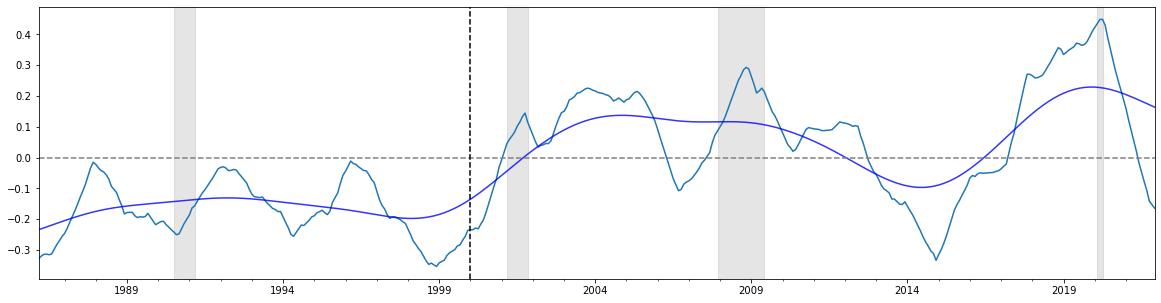

In [3]:
hp_kalman_plot(spx_betas, legend=False)

### What will be nice for final presentation is to plot smoothed vs non-smoothed and get rid of hp filter (like seriously trend's good enough already!)

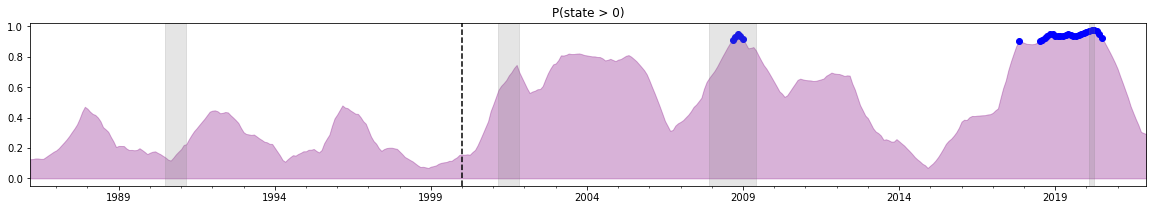

In [4]:
kalman_beta_model.plot_likelihood()

In [5]:
backtest(wti.contract_1, {'Kalman': kalman_beta_model.backtest()})

RMSE Random Walk: 0.9946960295396331
RMSE Kalman: 0.941619034632321


Recession periods are shaded in grey and a trendline was constructed using the Hodrick-Prescott filter. There appears to be an increase in equity risk post-financialization (dashed line indicating Jan 2000, around when financialization of commodity markets begun).

### MSCI World

The MSCI World index is comprised of equity indices from developed markets.

In [6]:
msci_world = clean_series('real', load('data/MSCI_World.csv').pct_change())
msci_world_betas = kalman_beta_model.run('contract_1', 'real', wti.join(msci_world).dropna(), smooth=True)

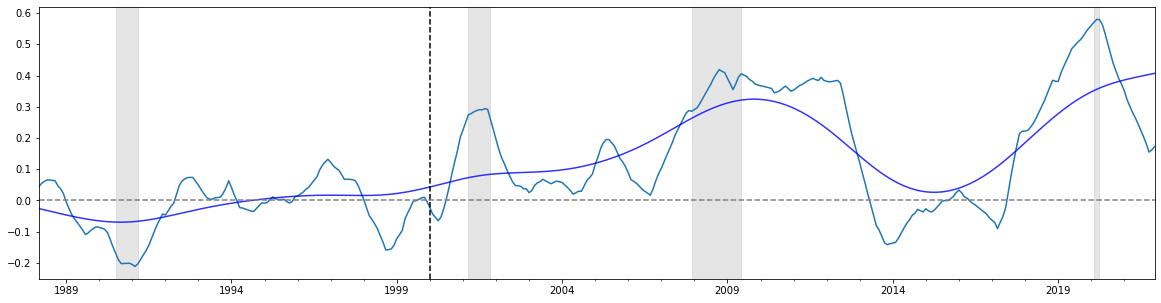

In [7]:
hp_kalman_plot(msci_world_betas, legend=False)

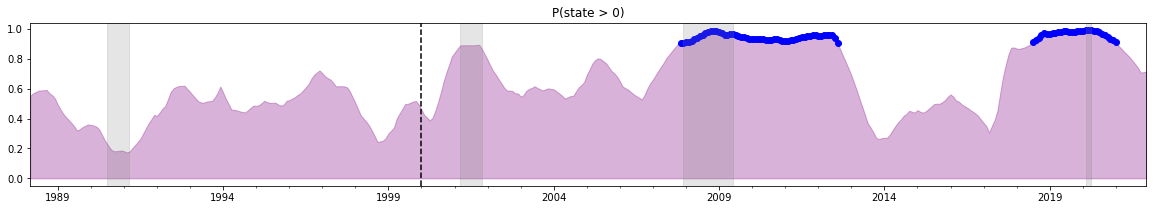

In [8]:
kalman_beta_model.plot_likelihood()

In [9]:
backtest(wti.contract_1, {'Kalman': kalman_beta_model.backtest()})

RMSE Random Walk: 0.9946960295396331
RMSE Kalman: 0.9444105379128922


### MSCI Emerging Markets

As its name suggests, MSCI Emerging Markets (EM) is an index for emerging market equities.

In [10]:
msci_em = clean_series('real', load('data/MSCI_EM.csv').pct_change())
msci_em_betas = kalman_beta_model.run('contract_1', 'real', wti.join(msci_em).dropna(), smooth=True)

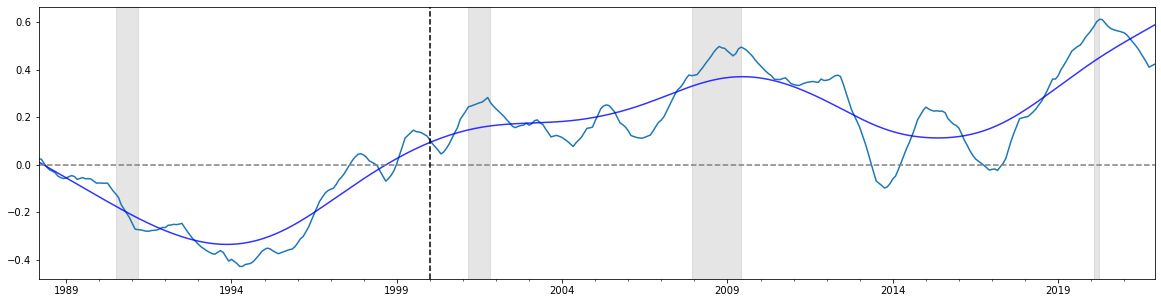

In [11]:
hp_kalman_plot(msci_em_betas, legend=False)

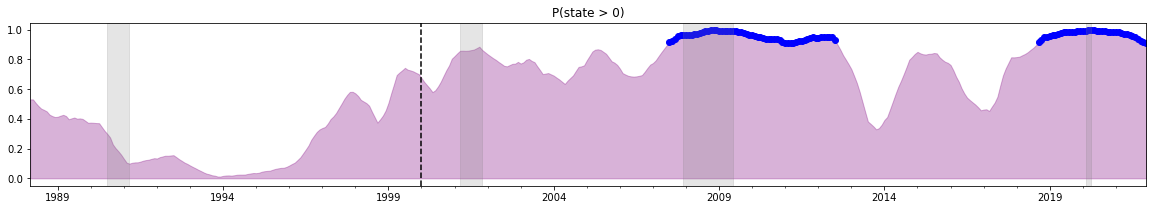

In [12]:
kalman_beta_model.plot_likelihood()

In [13]:
backtest(wti.contract_1, {'Kalman': kalman_beta_model.backtest()})

RMSE Random Walk: 0.9946960295396331
RMSE Kalman: 0.9285165850754076


A clear trend emerges from the MSCI indices for both the developed and developing equity markets - one that is robust to market cycles. Judging from the RMSE, the MSCI Emerging Markets index has a greater explainability for oil returns than the S&P 500 or MSCI World. The importance of developing market demand has been explored in Killian and Hicks (2013).

## 3. Commodity Market Risk

### GSCI Non-Energy

In [14]:
gsneci = clean_series('real', load('data/GSNECI.csv').pct_change())
gsneci_betas = kalman_beta_model.run('contract_1', 'real', wti.join(gsneci).dropna(), smooth=True)

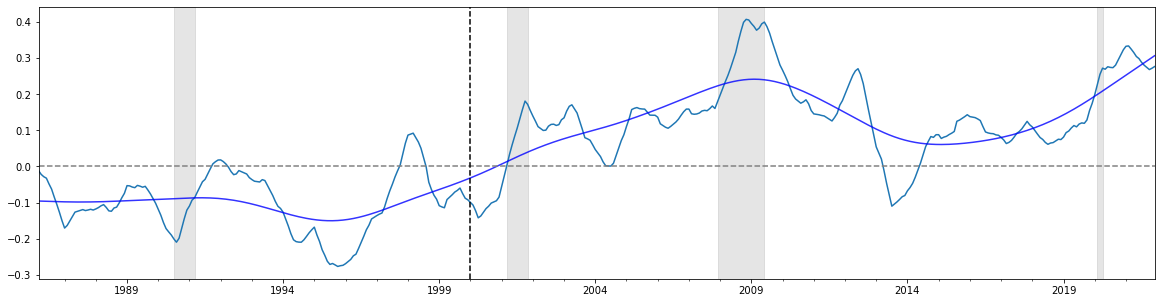

In [15]:
hp_kalman_plot(gsneci_betas, legend=False)

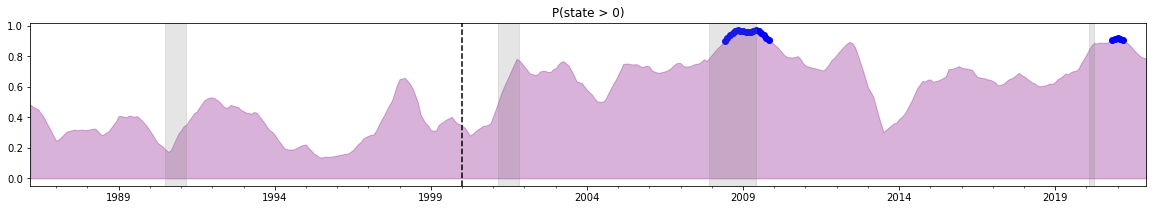

In [16]:
kalman_beta_model.plot_likelihood()

In [17]:
backtest(wti.contract_1, {'Kalman': kalman_beta_model.backtest()})

RMSE Random Walk: 0.9946960295396331
RMSE Kalman: 0.9572529739837426


It appears that not only is WTI being more closely correlated with equities and economic factors, but also commodities in general. These trends suggest that financialization increased the link between WTI to other markets such as equities and non-energy commodities, perhaps because financialization is by definition the inclusion of investors who previously did not have access to the market. It then makes sense that these investors would incorporate different information sets into their pricing.

### US Field Production

In [18]:
prod = clean_series('production', load('data/US_production.csv').pct_change())
prod_betas = kalman_beta_model.run('contract_1', 'production', wti.join(prod).dropna(), smooth=True)

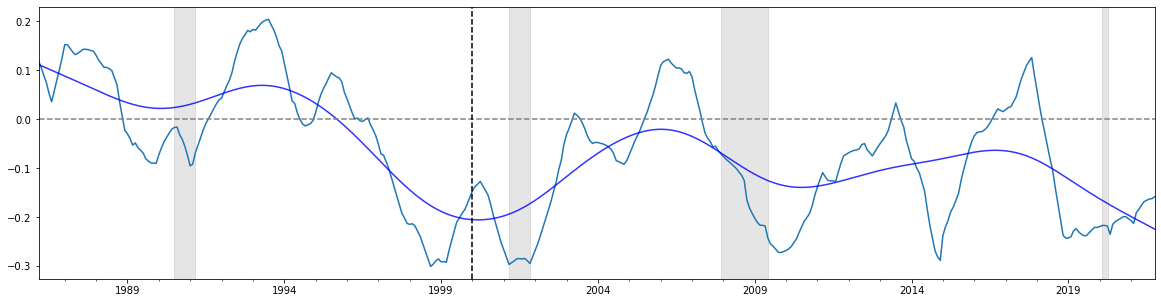

In [19]:
hp_kalman_plot(prod_betas, legend=False)

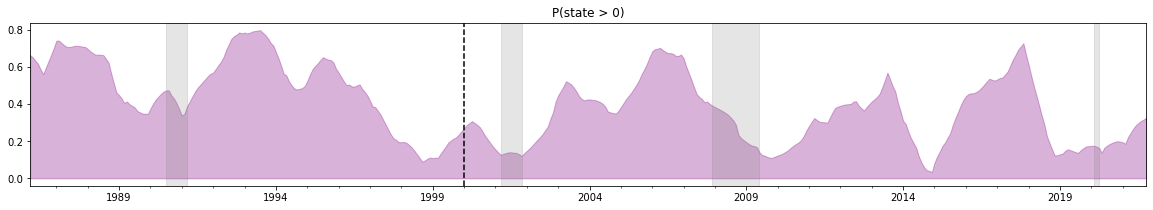

In [20]:
kalman_beta_model.plot_likelihood()

In [21]:
backtest(wti.contract_1, {'Kalman': kalman_beta_model.backtest()})

RMSE Random Walk: 0.9946960295396331
RMSE Kalman: 0.9586471514809631


### World Petroleum Production

In [22]:
prod = clean_series('production', load('data/Global_production.csv').pct_change())
prod_betas = kalman_beta_model.run('contract_1', 'production', wti.join(prod).dropna(), smooth=True)

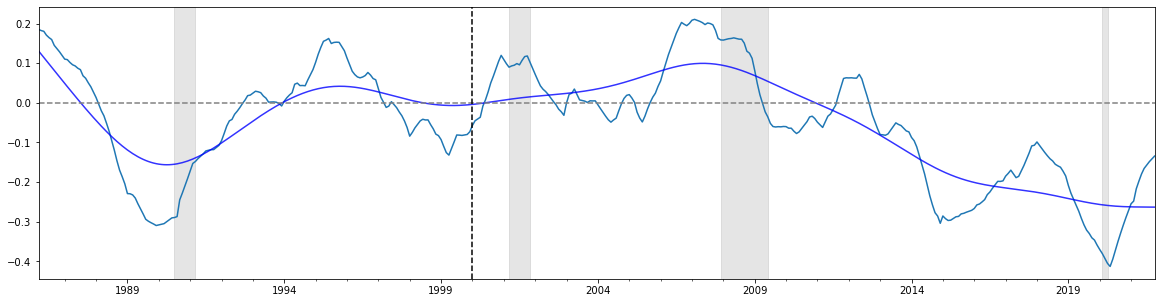

In [23]:
hp_kalman_plot(prod_betas, legend=False)

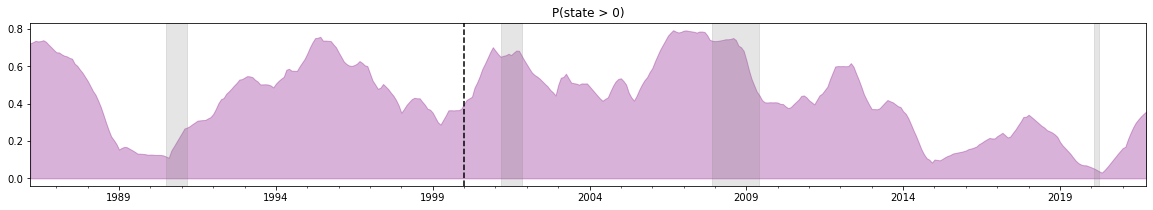

In [24]:
kalman_beta_model.plot_likelihood()

In [25]:
backtest(wti.contract_1, {'Kalman': kalman_beta_model.backtest()})

RMSE Random Walk: 0.9946960295396331
RMSE Kalman: 0.9652125084356127


## 4. General Commodity Trends

### GSCI & S&P 500

In [26]:
gsci = clean_series('real', load('data/GSCI.csv').pct_change()).rename(columns={'real': 'gsci'})

In [27]:
gsci_spx = kalman_beta_model.run('gsci', 'real', spx.join(gsci).dropna(), smooth=True)

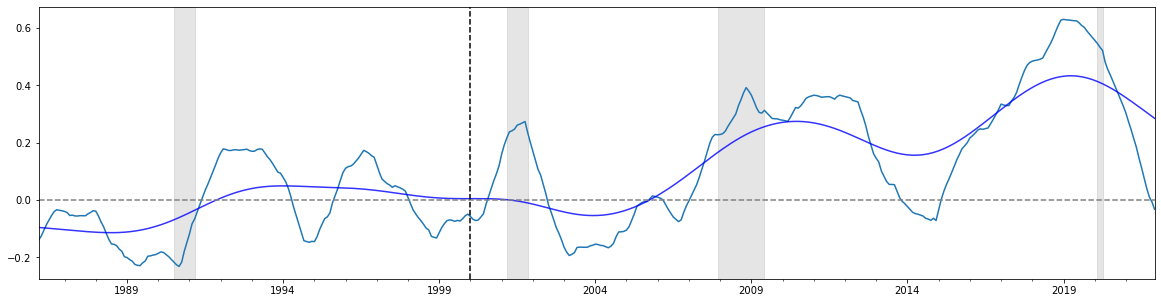

In [28]:
hp_kalman_plot(gsci_spx, legend=False)

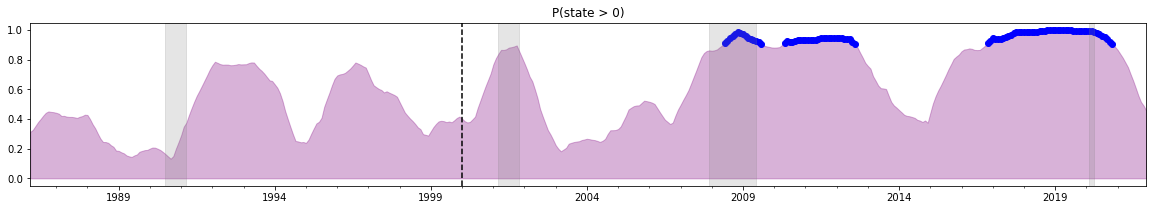

In [29]:
kalman_beta_model.plot_likelihood()

In [30]:
backtest(gsci.gsci, {'Kalman': kalman_beta_model.backtest()})

RMSE Random Walk: 0.9933042547314879
RMSE Kalman: 0.924718873819918


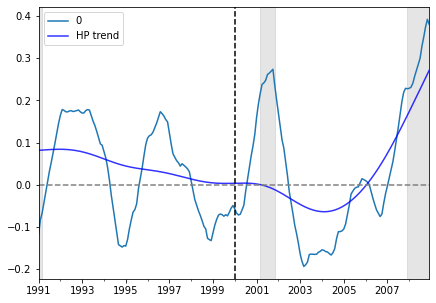

In [31]:
hp_kalman_plot(gsci_spx.loc['1991':'2008'], figsize=(7, 5))

Data confirms the correlations study on GSCI and S&P 500 done by Byukashin and Haigh (2009), but extends their data to see clear trends emerge around 2008 and 2019.

### GSCI & MSCI World

In [32]:
gsci_msci_w = kalman_beta_model.run('gsci', 'real', msci_world.join(gsci).dropna(), smooth=True)

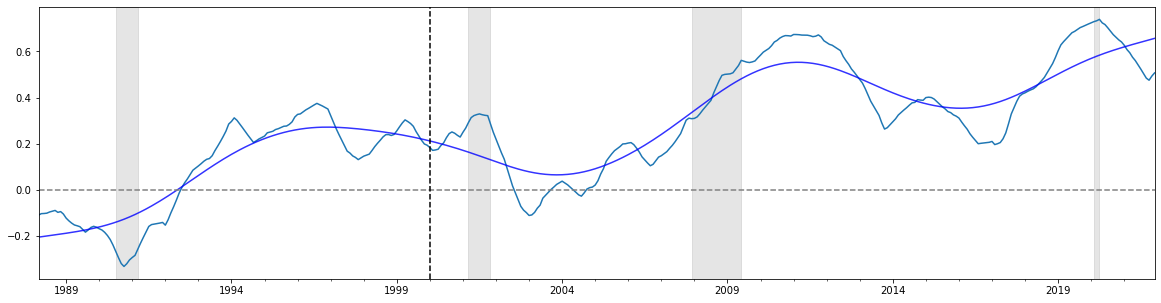

In [33]:
hp_kalman_plot(gsci_msci_w, legend=False)

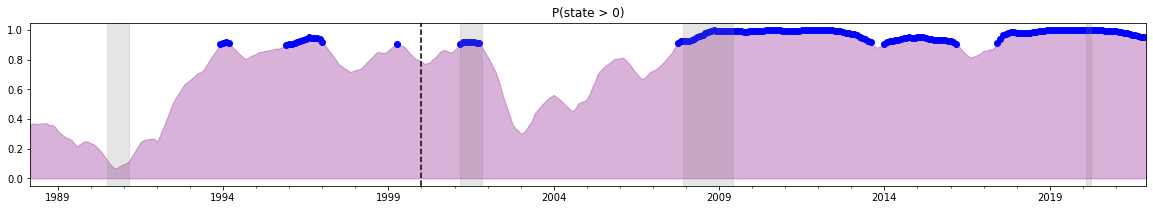

In [34]:
kalman_beta_model.plot_likelihood()

In [35]:
backtest(gsci.gsci, {'Kalman': kalman_beta_model.backtest()})

RMSE Random Walk: 0.9933042547314879
RMSE Kalman: 0.8977593058498401


### GSCI & MSCI Emerging Markets

In [36]:
gsci_msci_em = kalman_beta_model.run('gsci', 'real', msci_em.join(gsci).dropna(), smooth=True)

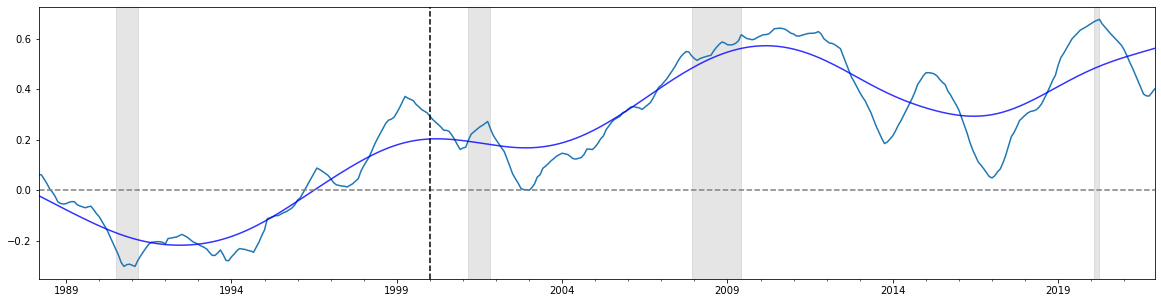

In [37]:
hp_kalman_plot(gsci_msci_em, legend=False)

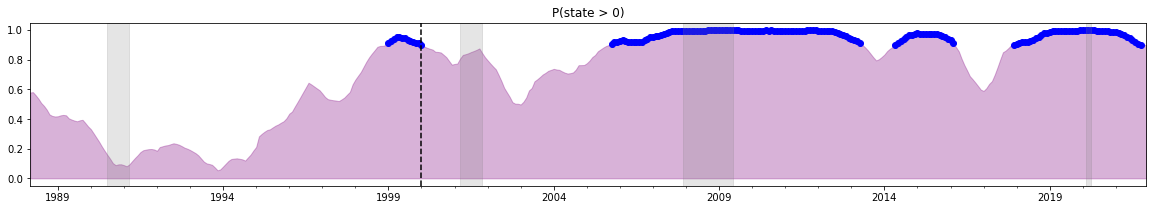

In [38]:
kalman_beta_model.plot_likelihood()

In [39]:
backtest(gsci.gsci, {'Kalman': kalman_beta_model.backtest()})

RMSE Random Walk: 0.9933042547314879
RMSE Kalman: 0.8995002272829173


### GSNECI & MSCI Emerging Markets

In [40]:
gsneci_msci_em = kalman_beta_model.run('gsneci', 'real', msci_em.join(gsneci.rename(columns={'real': 'gsneci'})).dropna(),
                                      smooth=True)

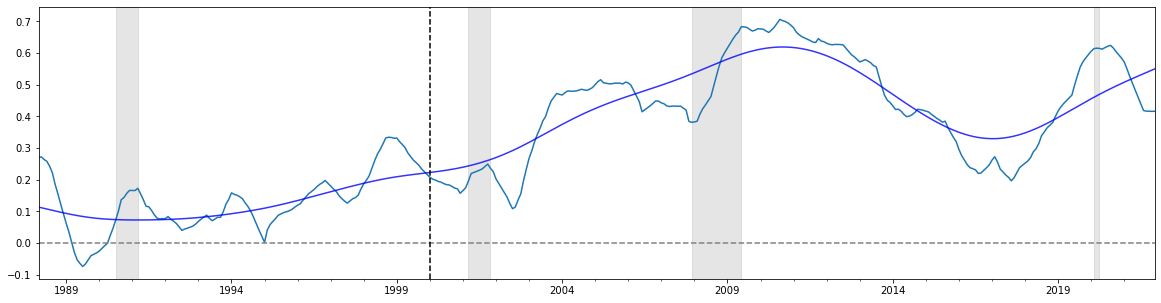

In [41]:
hp_kalman_plot(gsneci_msci_em, legend=False)

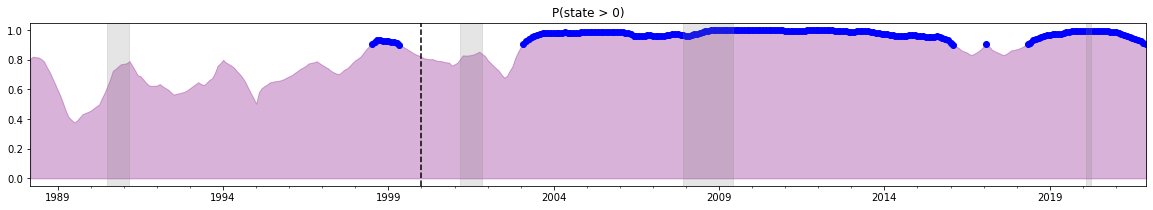

In [42]:
kalman_beta_model.plot_likelihood()

In [43]:
backtest(gsneci.real, {'Kalman': kalman_beta_model.backtest()})

RMSE Random Walk: 0.9748018233058424
RMSE Kalman: 0.8784202391660386


### GSCI Energy & MSCI Emerging Markets

In [44]:
gseci = clean_series('real', load('data/GSCI_energy.csv').pct_change())

In [45]:
gseci_msci_em = kalman_beta_model.run('gseci', 'real', msci_em.join(gseci.rename(columns={'real': 'gseci'})).dropna(),
                                     smooth=True)

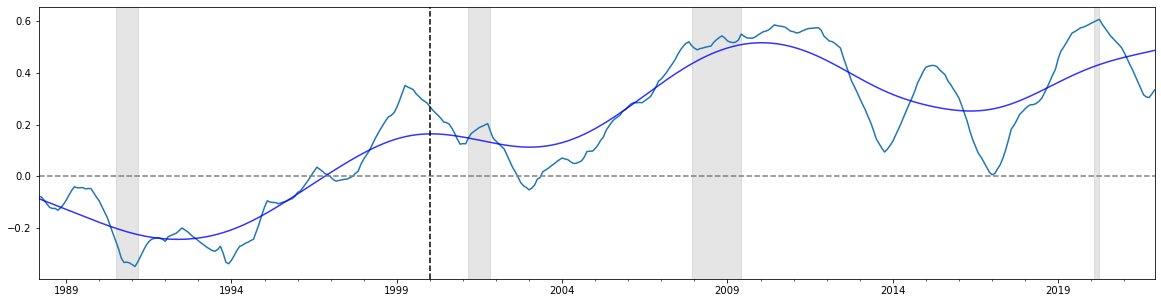

In [46]:
hp_kalman_plot(gseci_msci_em, legend=False)

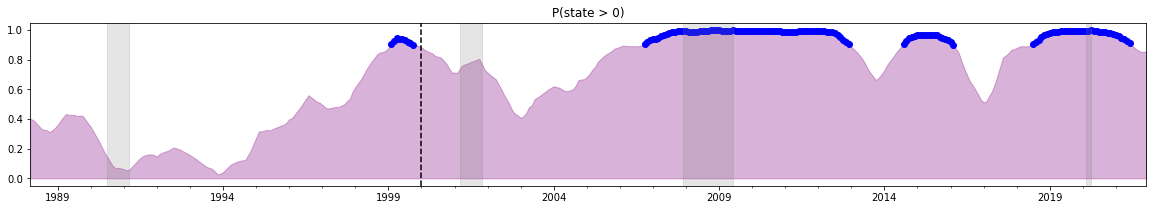

In [47]:
kalman_beta_model.plot_likelihood()

In [48]:
backtest(gseci.real, {'Kalman': kalman_beta_model.backtest()})

RMSE Random Walk: 0.9893678415049227
RMSE Kalman: 0.9040678370107692


This confirms Hu & Xiong's (2013) results that non-energy commodities have more predictive power for emerging markets than energy commodities.